# Chapter 4: Field data study Rockeskyller Kopf
# ME2 Inversions


<div class="alert alert-success">
    
This Notebook only reproduces the results of ``Sata/Rockeskyll/Res_ME2``. Visualization in Notebook 5.4.

In [8]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *
from datetime                   import datetime
from JointEntropyClass          import JointEntropyInversion as JEI

warnings.filterwarnings("ignore")

### Parameters and names

In [9]:
fig_dir = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-5/'
fn_dir  = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Data/Rockeskyll/'

fn_mesh = 'invmesh.bms'

fn_magnetic = 'Magnetic_data_corrected.csv'

fn_all = 'ert_data_rockes_all'

n_lines = 4 # number of lines
idx_list = [0, 2055, 4134, 5906, 7694] # for Pseudosection display

# PARAMETERS (based on Boxberg 2011)
F = 48487.4   # Median field intensity in nT

SEED = 420 # Random seed to ensure reproduceability

# Plotting
c_ert = 'gnuplot'
c_mag = cmr.tropical
lim_pseudos = [18,180]

### Importing Magnetic Data and Geometry

In [10]:
# %% READING DATA CSV-FILE
df = pd.read_csv(fn_dir+fn_magnetic, delimiter=',', decimal='.')
d_obs = df['F'].to_numpy()-F                                           # Total Field Anomaly numpy array
pnts = np.array([[df['X'][i], df['Y'][i], df['Z'][i]] for i in range(len(df))])

### Importing ERT Data

Text(0.5, 1.0, 'ERT Data')

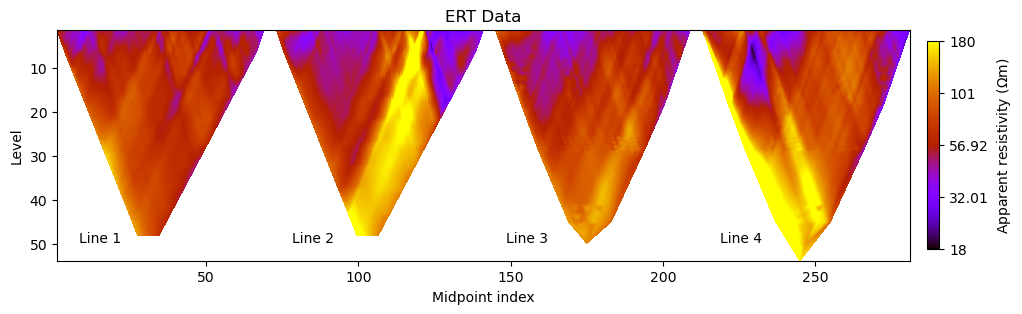

In [11]:
d_ert    = ert.load(fn_dir+fn_all)

# PLOT PSEUDOSECTIONS
%matplotlib inline
fig, ax = plt.subplots(figsize=(11,3))
showPseudosections(d_ert, d_ert['rhoa'].array(), idx_list, 4, ax=ax, clim=lim_pseudos, cmap=c_ert)
ax.set_title('ERT Data')

## Load Mesh

In [12]:
mesh = pg.load(fn_dir+fn_mesh)
mesh

Mesh: Nodes: 8381 Cells: 40005 Boundaries: 83717

### Magnetics 3D inversion

In [19]:
# Setup Inversion Manager
MAG, d_mag, relError = createMagManager(mesh, df)

# Create Starting model
startModel = pg.Vector(mesh.cellCount(), 1e-4) # surrounding rock has susceptibility of around 0.0001

   0%|          |0/294 [00:00 < ?]

In [20]:
# JEI Class Parameters
q = 2 
a = 60
lam = 0.01
beta = 1e-10

# Fix seed   
np.random.seed(SEED)

# Initiate Class
Jm = JEI(mgr_list=[MAG], data_list=[d_mag], mesh=mesh, order=q, beta=beta, 
                               smooth_factor=a)
KWm = dict(lam=lam, startModel=startModel, verbose=False, err=relError, limits=[0, 0.15])
Jm.setKWInv([KWm])
Jm.setNames(['MAG'])
Jm.setReferenceModel([startModel])


# Start Inversion
start_mag = datetime.now()
Jm.runInversion('ME', maxIter=50, chi_limit=2)
print(f'MAG Inversion took: {datetime.now()-start_mag}')

[sus] = Jm.getModels()

22/06/23 - 09:23:04 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... MAG


22/06/23 - 09:23:08 - pyGIMLi - INFO - Use median(data values)=355.6499999999978
22/06/23 - 09:23:08 - pyGIMLi - INFO - Created startmodel from forward operator: 40005 [355.6499999999978,...,355.6499999999978]


Starting iteration 1...
Set JME weights for MAG with q=2, b=1e-10 and a=60
#####     MAG weighted misfit chi^2   = 1272.36
#####     stabilizing functional    S = 3.26
#####     joint weighted misfit chi^2 = 1272.36
############################################################
       
Starting iteration 2...
Set JME weights for MAG with q=2, b=1e-10 and a=60
#####     MAG weighted misfit chi^2   = 1172.56
#####     stabilizing functional    S = 10.77
#####     joint weighted misfit chi^2 = 1172.56
############################################################
       
Starting iteration 3...
Set JME weights for MAG with q=2, b=1e-10 and a=60
#####     MAG weighted misfit chi^2   = 1094.58
#####     stabilizing functional    S = 10.69
#####     joint weighted misfit chi^2 = 1094.58
############################################################
       
Starting iteration 4...
Set JME weights for MAG with q=2, b=1e-10 and a=60
#####     MAG weighted misfit chi^2   = 1019.92
#####     stabilizin

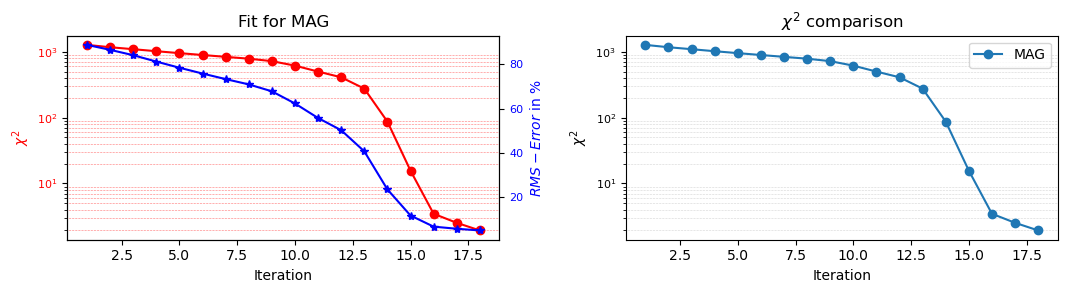

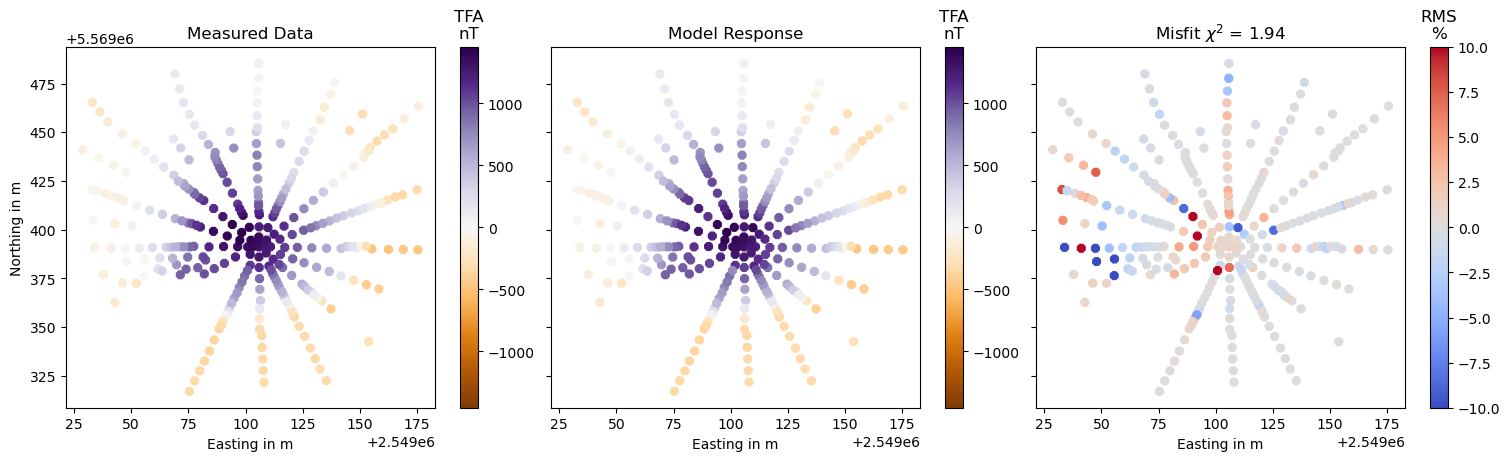

In [22]:
# Show result
%matplotlib inline
Jm.plotFitHistory()
plt.savefig(fig_dir+'ME2_MAG_fit.pdf', dpi=600, bbox_inches='tight')
fig, ax = showMagResult(pnts, MAG.inv)
plt.savefig(fig_dir+'ME2_MAG_overview.pdf', dpi=600, bbox_inches='tight')

# Get response and misfit and model
d_pre = np.array(MAG.inv.response,dtype=float) # Predicted data in numpy array
mag_misfit = 100*(d_obs-d_pre)/d_obs          # Misfit in %

# Save model and misfit
np.save(fn_dir+'Res_ME2/misfit_mag_me', mag_misfit)
np.save(fn_dir+'Res_ME2/sus_me', np.array(sus))

In [14]:
mesh['sus'] = sus
%matplotlib widget
pl, _ = pg.show(mesh, style="surface", cMap=c_mag, hold=True, notebook=False, alpha=0.2)
pv.drawMesh(pl, mesh, label="sus", style="surface", cMap=c_mag, alpha=0.7,
            filter={"threshold": dict(value=0.1, scalars="sus")})
pl.show()

### ERT 3D inversion

In [11]:
q = 2 
a = 15
lam = 0.01 
beta = 1e-10

ERT = ert.ERTManager(d_ert)

Je = JEI(mgr_list=[ERT], data_list=[d_ert], mesh=mesh, order=q, beta=beta, smooth_factor=a)

KWe = dict(lam=lam, verbose=True, limits=[1, 5e4])
Je.setKWInv([KWe])
Je.setNames(['ERT'])
Je.setReferenceModel([pg.Vector(mesh.cellCount(),67.41)])

start_ert = datetime.now()
Je.runInversion('ME', maxIter=10, chi_limit=5.5)
print(f'ERT Inversion took: {datetime.now()-start_ert}')

[res] = Je.getModels()

Starting Iteration 0...
... ERT


19/06/23 - 01:37:03 - pyGIMLi - INFO - Found 1 regions.
19/06/23 - 01:37:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/06/23 - 01:37:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/06/23 - 01:37:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 60473 Cells: 320040 Boundaries: 334868
19/06/23 - 01:37:49 - pyGIMLi - INFO - Use median(data values)=67.41308595645845
19/06/23 - 01:37:49 - pyGIMLi - INFO - Created startmodel from forward operator: 40005 [67.41308595645845,...,67.41308595645845]
19/06/23 - 01:37:49 - pyGIMLi - INFO - Starting inversion.
19/06/23 - 01:37:49 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000017949F7B040>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001792DE62AE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000178E65B9220>
min/max (data): 17.62/854
min/max (error): 3%/16.77%
min/max (start model): 67.41/67.41
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chiÂ² = 90.75 (dPhi = 37.88%) lam: 0.01
Starting iteration 1...
Set JME weights for ERT with q=2, b=1e-10 and a=25
#####     ERT weighted misfit chi^2   = 50.17
#####     stabilizing functional    S = 34.58
#####     joint weighted misfit chi^2 = 50.17
############################################################
       
Starting iteration 2...
Set JME weights for ERT with q=2, b=1e-10 and a=25
#####     ERT weighted misfit chi^2   = 31.68
#####     stabilizing function

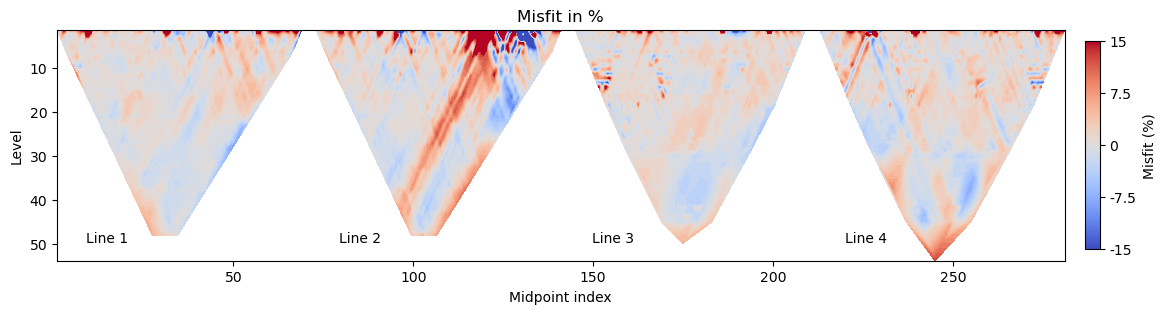

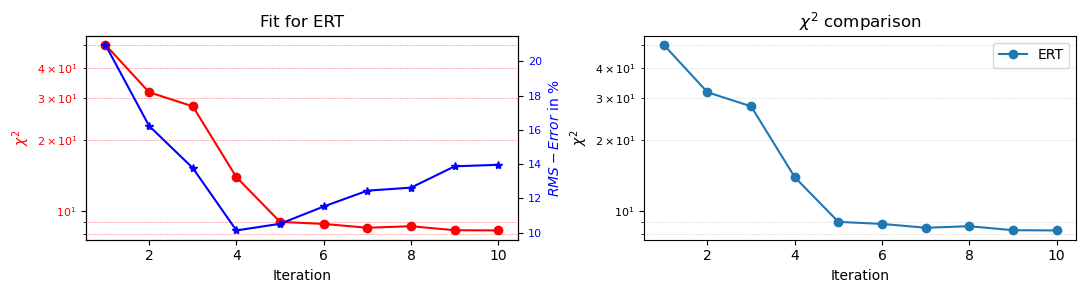

In [12]:
# Save in Model and mesh
np.save(fn_dir+'Res_ME2/res_me', ERT.model)

misfit_3d =  100*(d_ert['rhoa'].array()-ERT.inv.response.array())/d_ert['rhoa'].array()
np.save(fn_dir+'Res_ME2/misfit_ert_me', misfit_3d)

# SHow results
%matplotlib inline
fig, ax = plt.subplots(1,figsize=(13, 3))
showPseudosections(d_ert, misfit_3d, idx_list, 4, ax=ax, clim=[-15, 15], cmap='coolwarm', Type='misfit')
ax.set_title('Misfit in %')


Je.plotFitHistory()
plt.savefig(fig_dir+'ME2_ERT_fit.pdf', dpi=600, bbox_inches='tight')